Ref:
- https://colab.research.google.com/drive/1FbuTOevZTUO3IEVJLwSfwCdGnrBf3Qwv#scrollTo=RI6e9_68HvQe
- https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb   
- 一次只能解释一张图片，无法用于视频

In [2]:
import torch
from torchsummaryX import summary
from dataset import PhoenixDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torchtext.data import Field
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

import os
import pandas as pd
from jiwer import wer
from itertools import groupby
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import slic

## Load PhoenixDataset

In [3]:
TRG = Field(sequential=True, use_vocab=True,
            init_token=None, eos_token=None,
            lower=True, tokenize='spacy',
            tokenizer_language='de')

root = '/mnt/data/public/datasets'
csv_dir = os.path.join(root, 'phoenix2014-release/phoenix-2014-multisigner')
csv_dir = os.path.join(csv_dir, 'annotations/manual/train.corpus.csv')
csv_file = pd.read_csv(csv_dir)
tgt_sents = [csv_file.iloc[i, 0].lower().split('|')[3].split()
             for i in range(len(csv_file))]
TRG.build_vocab(tgt_sents, min_freq=1)
VocabSize = len(TRG.vocab)


def my_collate(batch):
    videos = [item['video'] for item in batch]
    videos = pad_sequence(videos, batch_first=True)
    annotations = [item['annotation'].split() for item in batch]
    annotations = TRG.process(annotations)
    return {'videos': videos, 'annotations': annotations}


transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1)),
    transforms.ToTensor()])

test_loader = DataLoader(
    PhoenixDataset(root, mode='test', transform=transform),
    batch_size=1, shuffle=False, num_workers=0,
    collate_fn=my_collate, pin_memory=True)

## Define test

In [4]:
def test(net, test_loader, device):
    net.eval()
    test_wer = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            inputs = batch['videos'].to(device)
            targets = batch['annotations'].to(device)
            outs = net(inputs)
            
            outs = outs.max(-1)[1].permute(1,0).contiguous().view(-1)
            outs = ' '.join([TRG.vocab.itos[i] for i,_ in groupby(outs) if i != VocabSize])
            targets = ' '.join([TRG.vocab.itos[i] for i in targets.view(-1)])
            test_wer.append(wer(targets, outs, standardize=True))
    return test_wer
            

## Load model

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
root1 = '/home/xieliang/Data/sign-language-recognition'
net_path = os.path.join(root1, 'save/CNN_GRU_CTC_total9.pth')
net = torch.load(net_path, map_location=device)

## Test

In [4]:
test_wer = test(net, test_loader, device)
for idx, wer in enumerate(test_wer):
    print(idx, wer)

0 0.8333333333333334
1 0.7142857142857143
2 0.42857142857142855
3 0.3333333333333333
4 0.7
5 0.4666666666666667
6 0.4
7 0.45454545454545453
8 0.4
9 0.5
10 0.5
11 0.14285714285714285
12 0.5
13 0.5
14 0.6363636363636364
15 0.0
16 0.2222222222222222
17 0.2
18 0.3333333333333333
19 0.5555555555555556
20 0.5555555555555556
21 0.4166666666666667
22 0.5
23 0.7
24 0.25
25 0.6666666666666666
26 0.7142857142857143
27 0.1111111111111111
28 0.375
29 0.6666666666666666
30 0.7777777777777778
31 0.7272727272727273
32 0.3333333333333333
33 0.5
34 0.3
35 0.0
36 0.4444444444444444
37 1.25
38 0.25
39 0.7272727272727273
40 0.5384615384615384
41 0.15384615384615385
42 0.3076923076923077
43 0.38461538461538464
44 0.45454545454545453
45 0.2
46 0.625
47 0.35714285714285715
48 0.5555555555555556
49 0.14285714285714285
50 0.2
51 0.25
52 0.6666666666666666
53 0.25
54 0.5555555555555556
55 0.5
56 0.375
57 0.25
58 0.23529411764705882
59 0.25
60 0.3333333333333333
61 0.2857142857142857
62 0.2222222222222222
63 0.42

## Visualize

tensor([  4, 243,  12,   8,   3], device='cuda:0')
tensor([   4, 1233,  243, 1233,   12, 1233, 1233,    8,    8, 1233, 1233,    3],
       device='cuda:0')


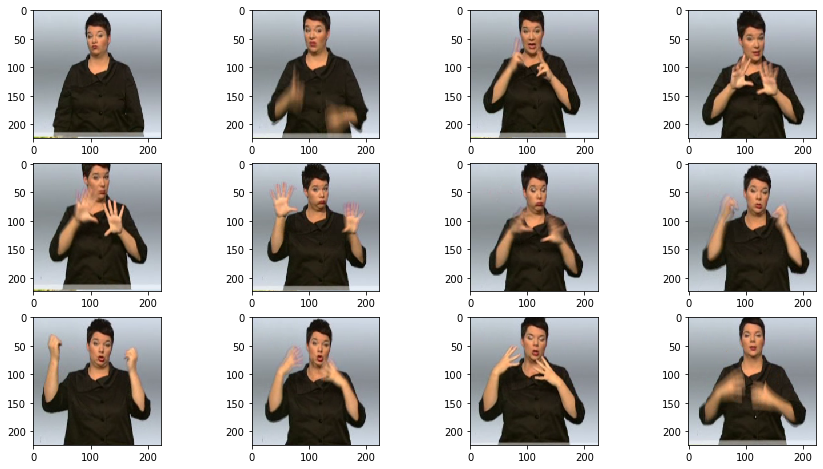

In [36]:
fig, axs = plt.subplots(3,4,figsize=(15,8))
for sample_idx, sample in enumerate(test_loader):
    if sample_idx == 35:
        inputs = sample['videos'].to(device)
        targets= sample['annotations'].to(device)
        outs = net(inputs).max(-1)[1]

        print(targets.view(-1))
        print(outs.view(-1))
        
        inputs = inputs[0].permute(0,2,3,1).detach().cpu().numpy()
        
        idx=0
        for i in range(3):
            for j in range(4):
                axs[i][j].imshow(inputs[idx])
                idx+=1
        plt.show()
        
        break

## Lime

In [9]:
def predict(inputs):
    net.eval()
    inputs = torch.FloatTensor(inputs).permute(0, 1, 4, 2, 3).to(device)
    outs = net(inputs)
    return outs.detach().cpu().numpy()


def segmentation(inputs):
    return slic(inputs, n_segments=100, compactness=1, sigma=1)


for sample_idx, sample in enumerate(test_loader):
    if sample_idx == 35:
        inputs = sample['videos']
        inputs = inputs[0].permute(0,2,3,1).detach().numpy()

        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            inputs, predict, top_labels=5, hide_color=0,
            num_samples=1000, segmentation_fn=segmentation)

        lime_image, mask = explanation.get_image_and_mask(
            explanation.top_labels[0], positive_only=False,
            num_features=1234, hide_rest=False, min_weight=0.05)

        print(lime_image.shape)

        break

IndexError: index 51 is out of bounds for axis 1 with size 10